# Tesla Stock Price Prediction, Test Bed
### Second Semester Capstone

This notebook is structured for testing the different parameters and seeing what affect they have on model results. Lessons learned from notebooks like LSTMFeaturePrune, LSTM365AtOnce, etc have all been merged into this one file. It should be able to do lookback and lookforward and stuff like that.

#### Notes:

When testing multi-step prediction with 365 days, a lower percent train was found to produce better results. (70% train versus 80% train). Also got better results when using more recent data. I grabbed a new Tesla stock CSV from Yahoo Finance that now leads up to 12/31/2021. Prior tests with the previous data set yielded results of about 69% error at best

<ins>Current Best Results with 365 Day Multistep Prediction:</ins>
<br>28.61% error
<br><ins>Parameters:</ins>
<br>n_in = 30
<br>n_out = 365
<br>n_predict = 1
<br>percent_train = 0.70
<br>n_epochs = 50
<br>batch_size = 60
<br>n_neurons = 40
<br>dropout = 0.00
<br>learning_rate = 0.001
<br>Start Date = 2019-01-02

<ins>Current Best Results with 90 Day Multistep Prediction:</ins>
<br>8.60% error
<br><ins>Parameters:</ins>
<br>n_in = 10
<br>n_out = 90
<br>n_predict = 1
<br>percent_train = 0.70
<br>n_epochs = 100
<br>batch_size = 150
<br>n_neurons = 40
<br>dropout = 0.00
<br>learning_rate = 0.001
<br>Start Date = 2019-01-02

In [235]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [236]:
# Loading Preprocessed Data File
df = pd.read_csv("preprocessed_MoreRecent.csv",usecols=['Date','Close','Tesla Trend','Musk Trend','Month','Day of the Month','Day of the Week'], parse_dates=['Date'],index_col=0)
#df = pd.read_csv("preprocessed_MoreRecent.csv", parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)
df = df.loc[(df.index >= '2019-01-01')]

print(df.shape)
df.head()

(757, 6)


,Close,Tesla Trend,Musk Trend,Month,Day of the Month,Day of the Week
Date,,,,,,
2019-01-02,62.023998,22.00,4.30,1,2,2
2019-01-03,60.071999,19.36,3.55,1,3,3
2019-01-04,63.537998,17.16,4.80,1,4,4
2019-01-07,66.991997,13.80,4.05,1,7,0
2019-01-08,67.070000,13.80,3.45,1,8,1


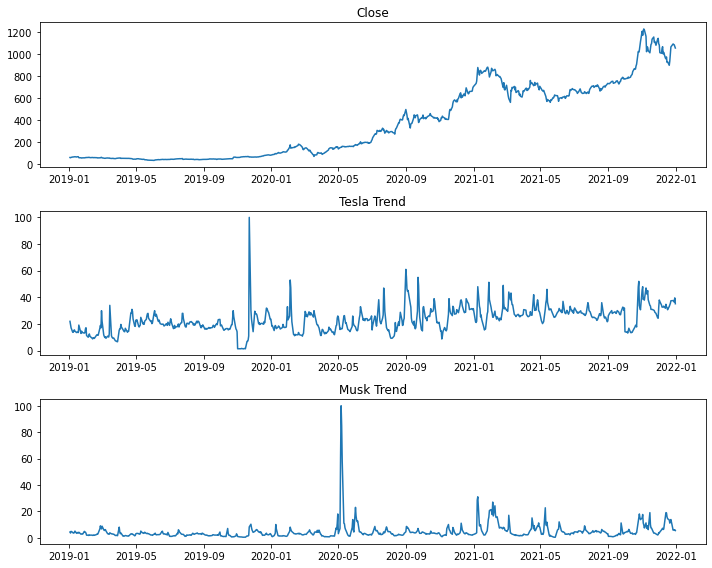

In [237]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(10,8))
pyplot.subplot(3, 1, 1)
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.subplot(3, 1, 2)
pyplot.plot(dates, df["Tesla Trend"], label="Tesla Trend")
pyplot.title("Tesla Trend")
pyplot.subplot(3, 1, 3)
pyplot.plot(dates, df["Musk Trend"], label="Musk Trend")
pyplot.title("Musk Trend")
pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [238]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Conversion of Time Series Data

In [239]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features, makes it easier for the model to train on
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [240]:
n_in = 10               # look back
n_out = 90              # look forward
n_predict = 1           # n_predict = number of data points you want to predict / n_out
percent_train = 0.70    # percent as decimal

# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, n_in, n_out)
# Drop Columns of Variables We Aren't Predicting
for i in range(1, n_out):
#    reframed.drop(reframed.loc[:, ('Open(t+%i)' %(i)):('Low(t+%i)' %(i))], axis=1, inplace=True)
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Day of the Week(t+%i)' %(i))], axis=1, inplace=True)
#reframed.drop(reframed.loc[:, 'Open(t)':'Low(t)'], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Day of the Week(t)'], axis=1, inplace=True)

y_vals = reframed.iloc[:,n_out*-1:].values
x_vals = reframed.iloc[:,:n_out*-1].values
# split into train, test, and prediction sets
n_train = floor((len(x_vals)-n_predict) * percent_train)
# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((n_train, n_in, len(df.columns)))
test_X = test_X.reshape((test_X.shape[0], n_in, len(df.columns)))
predict_X = predict_X.reshape((n_predict, n_in, len(df.columns)))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)
reframed.head()

(459, 10, 6) (459, 90) (198, 10, 6) (198, 90) (1, 10, 6) (1, 90)


,Close(t-10),Tesla Trend(t-10),Musk Trend(t-10),Month(t-10),Day of the Month(t-10),Day of the Week(t-10),Close(t-9),Tesla Trend(t-9),Musk Trend(t-9),Month(t-9),...,Close(t+80),Close(t+81),Close(t+82),Close(t+83),Close(t+84),Close(t+85),Close(t+86),Close(t+87),Close(t+88),Close(t+89)
10,0.021966,0.209085,0.039542,0.0,0.033333,0.50,0.020331,0.182316,0.032015,0.0,...,0.008046,0.008934,0.008874,0.008267,0.005370,0.004420,0.004373,0.002305,0.002767,0.001953
11,0.020331,0.182316,0.032015,0.0,0.066667,0.75,0.023234,0.160008,0.044560,0.0,...,0.008934,0.008874,0.008267,0.005370,0.004420,0.004373,0.002305,0.002767,0.001953,0.001630
12,0.023234,0.160008,0.044560,0.0,0.100000,1.00,0.026126,0.125938,0.037033,0.0,...,0.008874,0.008267,0.005370,0.004420,0.004373,0.002305,0.002767,0.001953,0.001630,0.001824
13,0.026126,0.125938,0.037033,0.0,0.200000,0.00,0.026192,0.125938,0.031012,0.0,...,0.008267,0.005370,0.004420,0.004373,0.002305,0.002767,0.001953,0.001630,0.001824,0.001549
14,0.026192,0.125938,0.031012,0.0,0.233333,0.25,0.026724,0.140134,0.035528,0.0,...,0.005370,0.004420,0.004373,0.002305,0.002767,0.001953,0.001630,0.001824,0.001549,0.001037


## Running Model

### Function For Running Model

In [241]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [242]:
# Design Network
def fit_lstm(train_X, train_y, test_X, test_y, n_out, batch_size, n_epochs, n_neurons, dropout=0.0, lr=0.001, v=0):

    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))
    model.add(Dense(n_out, activation="linear", kernel_constraint=NonNeg()))

    opt = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=opt, metrics=['accuracy'])

    # fit network
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=v, shuffle=False)

    # Return model, model training history, and prediction
    return model, history

### Testing Loop

Batch Size = 60
Trial 1 Normalized RMSE: 0.1988 | Trial 2 Normalized RMSE: 0.1746 | Trial 3 Normalized RMSE: 0.2227 | Trial 4 Normalized RMSE: 0.2019 | Trial 5 Normalized RMSE: 0.2166 | 


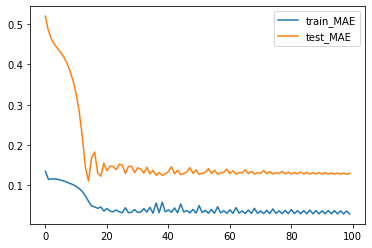

Best NRMSE: 0.1746

Batch Size = 100
Trial 1 Normalized RMSE: 0.2303 | Trial 2 Normalized RMSE: 0.1848 | Trial 3 Normalized RMSE: 0.2013 | Trial 4 Normalized RMSE: 0.2179 | Trial 5 Normalized RMSE: 0.2122 | 


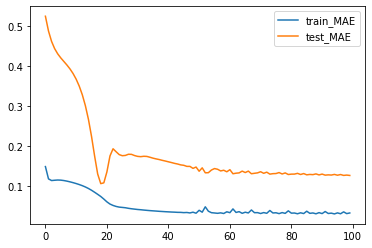

Best NRMSE: 0.1848

Batch Size = 150
Trial 1 Normalized RMSE: 0.1125 | Trial 2 Normalized RMSE: 0.0860 | Trial 3 Normalized RMSE: 0.1023 | Trial 4 Normalized RMSE: 0.1144 | Trial 5 Normalized RMSE: 0.1217 | 


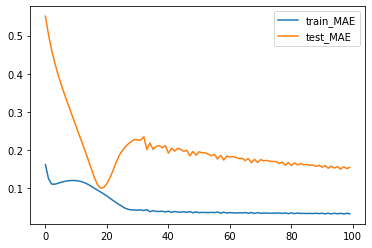

Best NRMSE: 0.0860

Batch Size = 200
Trial 1 Normalized RMSE: 0.1815 | Trial 2 Normalized RMSE: 0.1931 | Trial 3 Normalized RMSE: 0.1858 | Trial 4 Normalized RMSE: 0.1917 | Trial 5 Normalized RMSE: 0.1691 | 


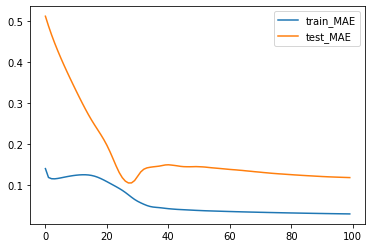

Best NRMSE: 0.1691

Batch Size = 250
Trial 1 Normalized RMSE: 0.1428 | Trial 2 Normalized RMSE: 0.1620 | Trial 3 Normalized RMSE: 0.1596 | Trial 4 Normalized RMSE: 0.1566 | Trial 5 Normalized RMSE: 0.1621 | 


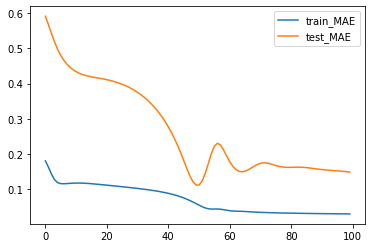

Best NRMSE: 0.1428

Batch Size = 300
Trial 1 Normalized RMSE: 0.1812 | Trial 2 Normalized RMSE: 0.1578 | Trial 3 Normalized RMSE: 0.1491 | Trial 4 Normalized RMSE: 0.1354 | Trial 5 Normalized RMSE: 0.1394 | 


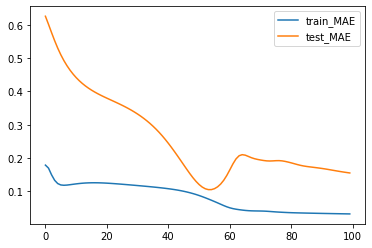

Best NRMSE: 0.1354

Batch Size = 400
Trial 1 Normalized RMSE: 0.1487 | Trial 2 Normalized RMSE: 0.1417 | Trial 3 Normalized RMSE: 0.1358 | Trial 4 Normalized RMSE: 0.1421 | Trial 5 Normalized RMSE: 0.1446 | 


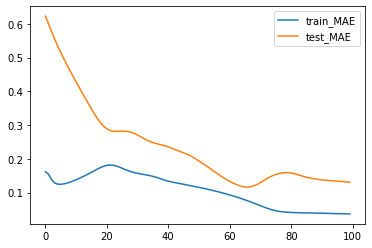

Best NRMSE: 0.1358

Batch Size = 500
Trial 1 Normalized RMSE: 0.1462 | Trial 2 Normalized RMSE: 0.1720 | Trial 3 Normalized RMSE: 0.1567 | Trial 4 Normalized RMSE: 0.1424 | Trial 5 Normalized RMSE: 0.1297 | 


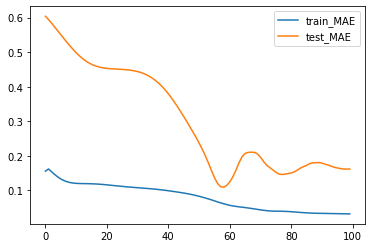

Best NRMSE: 0.1297

Batch Size = 600
Trial 1 Normalized RMSE: 0.1398 | Trial 2 Normalized RMSE: 0.1297 | Trial 3 Normalized RMSE: 0.1468 | Trial 4 Normalized RMSE: 0.1352 | Trial 5 Normalized RMSE: 0.1303 | 


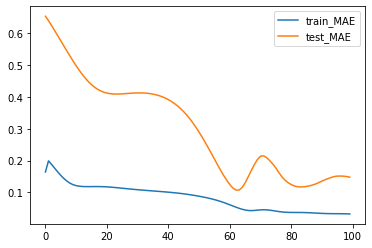

Best NRMSE: 0.1297

Batch Size = 700
Trial 1 Normalized RMSE: 0.1380 | Trial 2 Normalized RMSE: 0.1498 | Trial 3 Normalized RMSE: 0.1424 | Trial 4 Normalized RMSE: 0.1489 | Trial 5 Normalized RMSE: 0.1377 | 


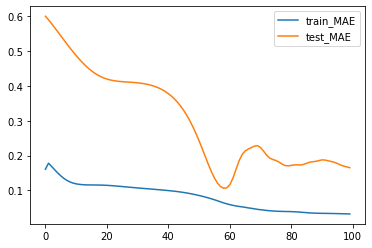

Best NRMSE: 0.1377

Batch Size = 800
Trial 1 Normalized RMSE: 0.1447 | Trial 2 Normalized RMSE: 0.1440 | Trial 3 Normalized RMSE: 0.1446 | Trial 4 Normalized RMSE: 0.1627 | Trial 5 Normalized RMSE: 0.1331 | 


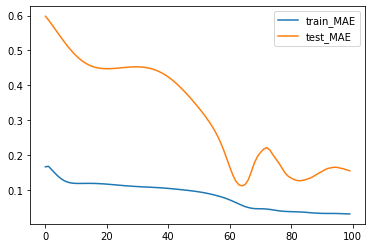

Best NRMSE: 0.1331



In [243]:
from sklearn.metrics import mean_squared_error

# Adjustable Hyperparameters
n_trials = 5
n_epochs = 100
batch_size = 700
n_neurons = 40
dropout = 0.00                                      # default is 0.0
learning_rate = 0.001                               # default is 0.001
testingArray = [60, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]
verbose = 0                                         # 0, 1, or 2
thingTested = "Batch Size"                          # just for output purposes

# Results Dictionary
results = {}
results["best_nrmse"] = {}
results["best_history"] = {}
results["best_invy"] = {}
results["best_invyhat"] = {}
results["best_model"] = {}
scaler.fit(df["Close"].values.reshape(-1,1))
inv_y = scaler.inverse_transform(predict_y).reshape(n_out*n_predict)

for testingThing in testingArray:
    print("%s = %s" %(thingTested, testingThing))
    for r in range(n_trials):
        print("Trial %i " %(r+1), end="")
        model, history = fit_lstm(
            train_X, train_y, test_X, test_y, n_out, # Move testingThing to whatever parameter you're testing
            batch_size=testingThing,                
            n_epochs=n_epochs,
            n_neurons=n_neurons,
            dropout=dropout,
            lr=learning_rate,
            v=verbose
        )
        # Make Prediction
        yhat = model.predict(predict_X)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
        # calculate RMSE and NRMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        normalized_rmse = rmse/(mean(inv_y))
        print('Normalized RMSE: %.4f | ' % normalized_rmse, end="")
        # Store the model with the best NRMSE
        if testingThing not in results["best_nrmse"] or normalized_rmse < results["best_nrmse"][testingThing]:
            results["best_nrmse"][testingThing] = normalized_rmse
            results["best_history"][testingThing] = history
            results["best_invyhat"][testingThing] = inv_yhat
            results["best_model"][testingThing] = model
            if "overall_best" not in results["best_nrmse"] or normalized_rmse < results["best_nrmse"]["overall_best"]:
                results["best_nrmse"]["overall_best"] = normalized_rmse
                results["best_history"]["overall_best"] = history
                results["best_invyhat"]["overall_best"] = inv_yhat
                results["best_model"]["overall_best"] = model
    print()
    pyplot.figure()
    pyplot.plot(results["best_history"][testingThing].history['loss'], label='train_MAE')
    pyplot.plot(results["best_history"][testingThing].history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()
    print("Best NRMSE: %.4f\n" %(results["best_nrmse"][testingThing]))

## Results

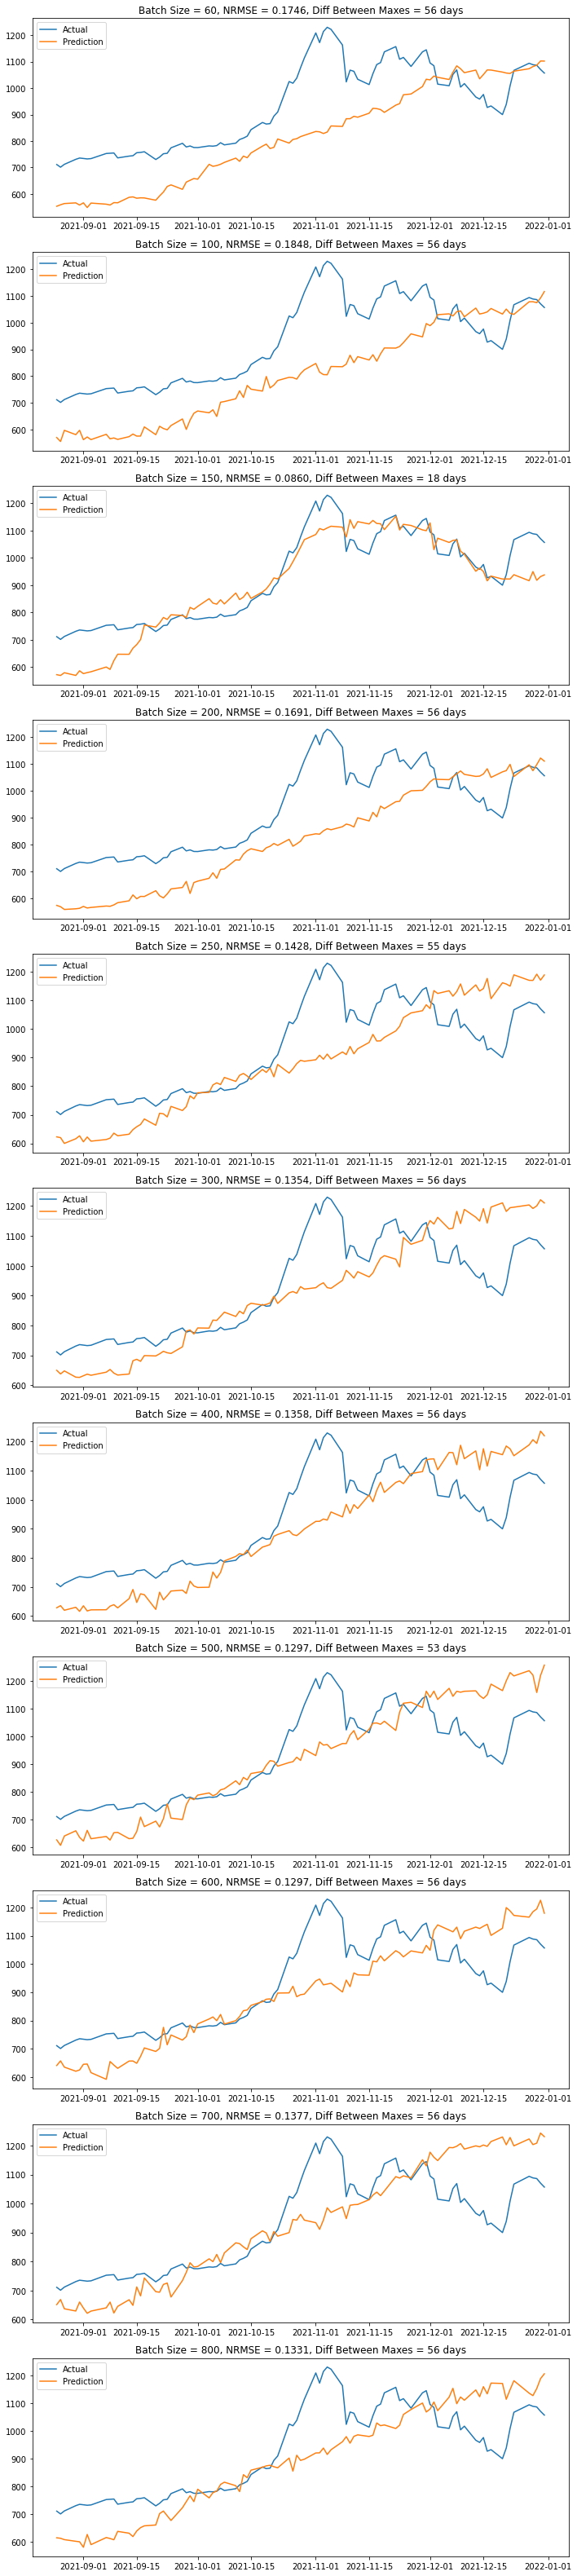

In [244]:
predictDates = dates[len(dates)-(n_out*n_predict):]
pyplot.figure(figsize=(10,4*len(testingArray)))
i = 1
for testingThing in testingArray:
    
    inv_yhat = results["best_invyhat"][testingThing]
    maxes = [
        predictDates[np.argmax(inv_yhat[0:89], axis=0)], 
    ]
    maxes_actual = [
        predictDates[np.argmax(inv_y[0:89], axis=0)], 
    ]
    pyplot.subplot(len(testingArray), 1, i)
    pyplot.plot(predictDates, inv_y, label="Actual")
    pyplot.plot(predictDates, inv_yhat, label="Prediction")
    pyplot.legend(loc='upper left')
    pyplot.title("%s = %s, NRMSE = %.4f, Diff Between Maxes = %s" %(thingTested, testingThing, results["best_nrmse"][testingThing], abs((maxes_actual[0]-maxes[0]).astype('timedelta64[D]'))))

    i+= 1

pyplot.tight_layout()
pyplot.show()
    

In [245]:
inv_yhat = results["best_invyhat"]["overall_best"]

maxes = [
    predictDates[np.argmax(inv_yhat[0:89], axis=0)], 
]
maxes_actual = [
    predictDates[np.argmax(inv_y[0:89], axis=0)], 
]

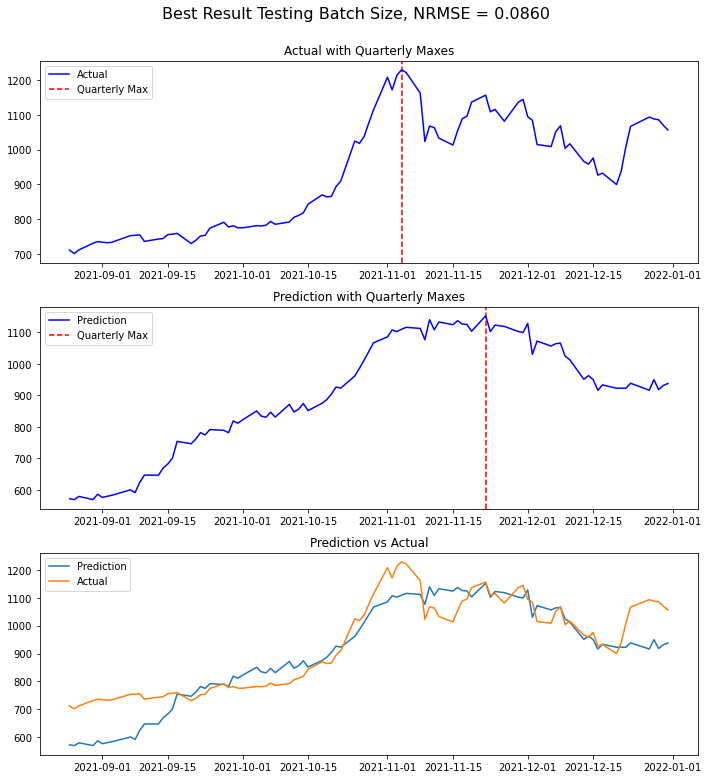

In [246]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,11))

pyplot.suptitle("Best Result Testing %s, NRMSE = %.4f\n" %(thingTested, results["best_nrmse"]["overall_best"]), fontsize=16)
pyplot.subplot(3, 1, 1)
pyplot.plot(predictDates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual with Quarterly Maxes")

pyplot.subplot(3, 1, 2)
pyplot.plot(predictDates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction with Quarterly Maxes")

pyplot.subplot(3,1,3)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Actual")

pyplot.tight_layout()
pyplot.show()

In [247]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i]))
    print("Diff: %s" %abs((maxes_actual[i]-maxes[i]).astype('timedelta64[D]')))

Q1 Max: 2021-11-22T00:00:00.000000000
Q1 Actual Max: 2021-11-04T00:00:00.000000000
Diff: 18 days


In [248]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(results["best_model"]["overall_best"], train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,len(df.columns)*n_in)
predict_X_2D = predict_X.reshape(-1, len(df.columns)*n_in)
print(predict_X_2D.shape, shap_values_2D.shape)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(1, 60) (1, 60)


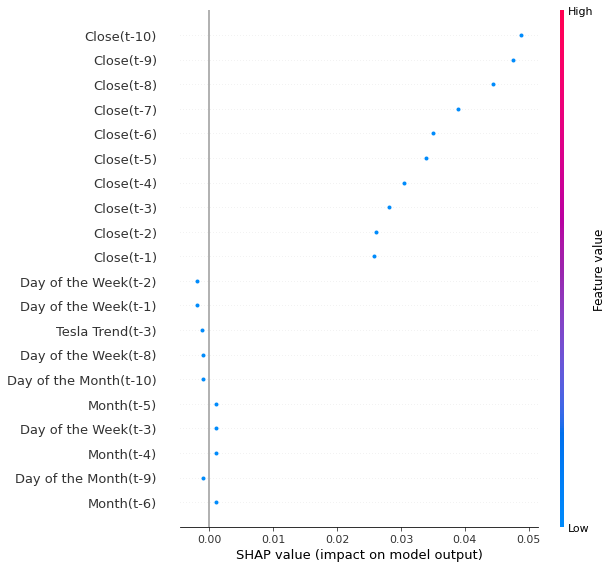

In [249]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=reframed.columns)